<a href="https://colab.research.google.com/github/kimjaehwankimjaehwan/deeplearningstudy/blob/main/ray_casper_%EB%B6%84%EB%A5%98.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import Input, models, layers, optimizers, metrics
from tensorflow.keras.layers import Dense, Flatten, Activation, Dropout
from tensorflow.keras.applications import VGG16
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import numpy as np
import matplotlib.pyplot as plt

# 데이터 전처리 생성기 설정
train_datagen = ImageDataGenerator(rescale=1./255,          # 주어진 이미지의 크기를 설정합니다.
                                  horizontal_flip=True,     # 수평 대칭 이미지를 50% 확률로 만들어 추가합니다.
                                  width_shift_range=0.1,    # 전체 크기의 15% 범위에서 좌우로 이동합니다.
                                  height_shift_range=0.1,   # 마찬가지로 위, 아래로 이동합니다.
                                  #rotation_range=5,        # 정해진 각도만큼 회전시킵니다.
                                  #shear_range=0.7,         # 좌표 하나를 고정시키고 나머지를 이동시킵니다.
                                  #zoom_range=1.2,          # 확대 또는 축소시킵니다.
                                  #vertical_flip=True,      # 수직 대칭 이미지를 만듭니다.
                                  #fill_mode='nearest'      # 빈 공간을 채우는 방법입니다. nearest 옵션은 가장 비슷한 색으로 채우게 됩니다.
                                  validation_split=0.2
                                  )



test_datagen = ImageDataGenerator(rescale=1./255)

# 학습용 데이터 (80%)
train_generator = train_datagen.flow_from_directory(
    '/content/drive/MyDrive/kdt_2506/data/cars/train',
    target_size=(299, 299),
    batch_size=32,
    class_mode='binary',
    subset='training',
    shuffle=True,
    seed=42
)

# 검증용 데이터 (20%)
validation_generator = train_datagen.flow_from_directory(
    '/content/drive/MyDrive/kdt_2506/data/cars/train',
    target_size=(299, 299),
    batch_size=32,
    class_mode='binary',
    subset='validation',
    shuffle=False,
    seed=42
)

# 테스트 데이터
test_generator = test_datagen.flow_from_directory(
    '/content/drive/MyDrive/kdt_2506/data/cars/test',
    target_size=(299, 299),
    batch_size=32,
    class_mode='binary',
    shuffle=False                   # 평가 시에는 shuffle 안함
)


Found 637 images belonging to 2 classes.
Found 158 images belonging to 2 classes.
Found 198 images belonging to 2 classes.


In [2]:
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout, Input
from tensorflow.keras.optimizers import Adam

# InceptionV3 base 모델 불러오기 (top 제거)
base_model = InceptionV3(
    weights='imagenet',
    include_top=False,
    input_tensor=Input(shape=(299, 299, 3))
)

# base 모델의 가중치는 동결 (feature extractor 용)
base_model.trainable = False

# 새로운 classifier 레이어 추가
x = base_model.output
x = GlobalAveragePooling2D()(x)  # Flatten 대신 평균 풀링
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)
output = Dense(1, activation='sigmoid')(x)  # 이진 분류용

# 전체 모델 구성
model = Model(inputs=base_model.input, outputs=output)

# 컴파일
model.compile(optimizer=Adam(learning_rate=1e-4),
              loss='binary_crossentropy',
              metrics=['accuracy'])

# summary
model.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 299, 299,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 149, 149,  │        864 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 149, 149,  │         96 │ conv2d[0][0]      │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, 149, 149,  │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 147, 147,  │      9,216 │ activation[0][0]  │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 147, 147,  │         96 │ conv2d_1[0][0]    │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_1        │ (None, 147, 147,  │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 147, 147,  │     18,432 │ activation_1[0][… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 147, 147,  │        192 │ conv2d_2[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_2        │ (None, 147, 147,  │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 73, 73,    │          0 │ activation_2[0][… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 73, 73,    │      5,120 │ max_pooling2d[0]… │
│                     │ 80)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 73, 73,    │        240 │ conv2d_3[0][0]    │
│ (BatchNormalizatio… │ 80)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_3        │ (None, 73, 73,    │          0 │ batch_normalizat… │
│ (Activation)        │ 80)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 71, 71,    │    138,240 │ activation_3[0][… │
│                     │ 192)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 71, 71,    │        576 │ conv2d_4[0][0]    │
│ (BatchNormalizatio… │ 192)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_4        │ (None, 71, 71,    │          0 │ batch_normalizat

 Total params: 22,327,585 (85.17 MB)

 Trainable params: 524,801 (2.00 MB)

 Non-trainable params: 21,802,784 (83.17 MB)

In [3]:
checkpoint = ModelCheckpoint('inceptionv3_best.keras', monitor='val_loss', save_best_only=True, verbose=0)
earlystop = EarlyStopping(monitor='val_loss', patience=10, verbose=1)

history = model.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=30,
    callbacks=[checkpoint, earlystop]
)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/30


/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor']
Received: inputs=Tensor(shape=(None, 299, 299, 3))
  warnings.warn(msg)


20/20 ━━━━━━━━━━━━━━━━━━━━ 65s 2s/step - accuracy: 0.5566 - loss: 0.7345 - val_accuracy: 0.8797 - val_loss: 0.3875
Epoch 2/30
20/20 ━━━━━━━━━━━━━━━━━━━━ 25s 1s/step - accuracy: 0.8457 - loss: 0.3834 - val_accuracy: 0.9114 - val_loss: 0.2627
Epoch 3/30
20/20 ━━━━━━━━━━━━━━━━━━━━ 26s 1s/step - accuracy: 0.9046 - loss: 0.2803 - val_accuracy: 0.9114 - val_loss: 0.2440
Epoch 4/30
20/20 ━━━━━━━━━━━━━━━━━━━━ 26s 1s/step - accuracy: 0.9054 - loss: 0.2438 - val_accuracy: 0.9177 - val_loss: 0.2138
Epoch 5/30
20/20 ━━━━━━━━━━━━━━━━━━━━ 25s 1s/step - accuracy: 0.9197 - loss: 0.2172 - val_accuracy: 0.9114 - val_loss: 0.2166
Epoch 6/30
20/20 ━━━━━━━━━━━━━━━━━━━━ 25s 1s/step - accuracy: 0.9456 - loss: 0.1777 - val_accuracy: 0.9114 - val_loss: 0.1992
Epoch 7/30
20/20 ━━━━━━━━━━━━━━━━━━━━ 26s 1s/step - accuracy: 0.9411 - loss: 0.1747 - val_accuracy: 0.9367 - val_loss: 0.1719
Epoch 8/30
20/20 ━━━━━━━━━━━━━━━━━━━━ 26s 1s/step - accuracy: 0.9504 - loss: 0.1590 - val_accuracy: 0.9430 - val_loss: 0.1640
Epo

In [4]:
loss, accuracy = model.evaluate(test_generator)

# 결과 출력
print(f"Test Loss: {loss:.4f}")
print(f"Test Accuracy: {accuracy:.4f}")

7/7 ━━━━━━━━━━━━━━━━━━━━ 30s 5s/step - accuracy: 0.9681 - loss: 0.1262
Test Loss: 0.1396
Test Accuracy: 0.9646


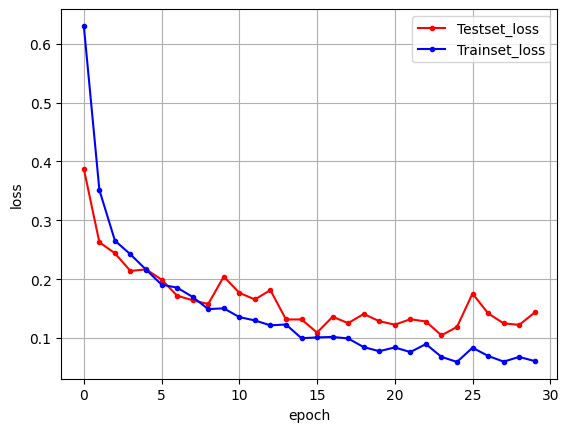

In [5]:
# 검증셋과 학습셋의 오차를 저장합니다.
y_vloss = history.history['val_loss']
y_loss = history.history['loss']

# 그래프로 표현해 봅니다.
x_len = np.arange(len(y_loss))
plt.plot(x_len, y_vloss, marker='.', c="red", label='Testset_loss')
plt.plot(x_len, y_loss, marker='.', c="blue", label='Trainset_loss')

# 그래프에 그리드를 주고 레이블을 표시하겠습니다.
plt.legend(loc='upper right')
plt.grid()
plt.xlabel('epoch')
plt.ylabel('loss')
plt.show()

In [6]:
# 학습용 데이터 (80%)
train_generator = train_datagen.flow_from_directory(
    '/content/drive/MyDrive/kdt_2506/data/cars/train',
    target_size=(150, 150),
    batch_size=32,
    class_mode='binary',
    subset='training',
    shuffle=True,
    seed=42
)

# 검증용 데이터 (20%)
validation_generator = train_datagen.flow_from_directory(
    '/content/drive/MyDrive/kdt_2506/data/cars/train',
    target_size=(150, 150),
    batch_size=32,
    class_mode='binary',
    subset='validation',
    shuffle=False,
    seed=42
)

# 테스트 데이터
test_generator = test_datagen.flow_from_directory(
    '/content/drive/MyDrive/kdt_2506/data/cars/test',
    target_size=(150, 150),
    batch_size=32,
    class_mode='binary',
    shuffle=False                   # 평가 시에는 shuffle 안함
)


Found 637 images belonging to 2 classes.
Found 158 images belonging to 2 classes.
Found 198 images belonging to 2 classes.


In [7]:
# base 모델: 입력 크기를 변경 (150x150x3)
base_model = InceptionV3(
    weights='imagenet',
    include_top=False,
    input_tensor=Input(shape=(150, 150, 3))
)

# 가중치 동결
base_model.trainable = False

# 커스텀 분류기 추가
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)
output = Dense(1, activation='sigmoid')(x)

model = Model(inputs=base_model.input, outputs=output)

# 컴파일
model.compile(optimizer=Adam(learning_rate=1e-4),
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [8]:
checkpoint = ModelCheckpoint('inceptionv3_best.keras', monitor='val_loss', save_best_only=True, verbose=0)
earlystop = EarlyStopping(monitor='val_loss', patience=10, verbose=1)

history = model.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=30,
    callbacks=[checkpoint, earlystop]
)

Epoch 1/30


/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_315']
Received: inputs=Tensor(shape=(None, 150, 150, 3))
  warnings.warn(msg)


20/20 ━━━━━━━━━━━━━━━━━━━━ 47s 2s/step - accuracy: 0.5456 - loss: 0.9848 - val_accuracy: 0.7911 - val_loss: 0.4402
Epoch 2/30
20/20 ━━━━━━━━━━━━━━━━━━━━ 15s 756ms/step - accuracy: 0.7371 - loss: 0.6026 - val_accuracy: 0.8544 - val_loss: 0.3467
Epoch 3/30
20/20 ━━━━━━━━━━━━━━━━━━━━ 15s 757ms/step - accuracy: 0.8083 - loss: 0.4369 - val_accuracy: 0.9051 - val_loss: 0.2587
Epoch 4/30
20/20 ━━━━━━━━━━━━━━━━━━━━ 14s 699ms/step - accuracy: 0.7856 - loss: 0.4524 - val_accuracy: 0.8987 - val_loss: 0.2895
Epoch 5/30
20/20 ━━━━━━━━━━━━━━━━━━━━ 15s 756ms/step - accuracy: 0.7936 - loss: 0.4523 - val_accuracy: 0.8987 - val_loss: 0.2338
Epoch 6/30
20/20 ━━━━━━━━━━━━━━━━━━━━ 15s 751ms/step - accuracy: 0.8393 - loss: 0.3773 - val_accuracy: 0.9241 - val_loss: 0.2089
Epoch 7/30
20/20 ━━━━━━━━━━━━━━━━━━━━ 15s 768ms/step - accuracy: 0.8534 - loss: 0.3195 - val_accuracy: 0.9241 - val_loss: 0.2019
Epoch 8/30
20/20 ━━━━━━━━━━━━━━━━━━━━ 15s 761ms/step - accuracy: 0.8950 - loss: 0.2698 - val_accuracy: 0.9177 -

In [9]:
loss, accuracy = model.evaluate(test_generator)

# 결과 출력
print(f"Test Loss: {loss:.4f}")
print(f"Test Accuracy: {accuracy:.4f}")

7/7 ━━━━━━━━━━━━━━━━━━━━ 8s 1s/step - accuracy: 0.8907 - loss: 0.2288
Test Loss: 0.3008
Test Accuracy: 0.8586


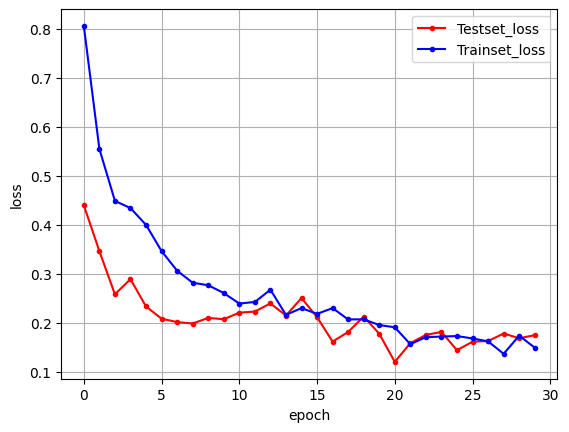

In [10]:
# 검증셋과 학습셋의 오차를 저장합니다.
y_vloss = history.history['val_loss']
y_loss = history.history['loss']

# 그래프로 표현해 봅니다.
x_len = np.arange(len(y_loss))
plt.plot(x_len, y_vloss, marker='.', c="red", label='Testset_loss')
plt.plot(x_len, y_loss, marker='.', c="blue", label='Trainset_loss')

# 그래프에 그리드를 주고 레이블을 표시하겠습니다.
plt.legend(loc='upper right')
plt.grid()
plt.xlabel('epoch')
plt.ylabel('loss')
plt.show()